# Estimating COVID-19's $R_t$ in Real-Time

In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;

In [88]:
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 5 # number of times to apply moving average filter to case data
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",SMOOTHING_PASSES)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=5


Case reporting is very erratic based on testing backlogs, etc. We apply a smoothing filter to the time series. A real world process is not nearly as stochastic as the actual reporting.

In [3]:
function moving_average(seq; alpha=0.5)
    vs = seq
    if length(vs) > 1
        ret = 
            # vcat( vs[1], [ alpha * vs[i] + (1 - alpha)*vs[i-1] for i = 2:length(vs) ] )
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [4]:
function smooth_sequence(seq)
    smooth_seq = copy(seq)
    for count in 1:SMOOTHING_PASSES
        smooth_seq = moving_average(smooth_seq) # approximates gaussian smoothing
    end
    return smooth_seq
end

smooth_sequence (generic function with 1 method)

## A Simulated outbreak

In [96]:
using Distributions, Plots
function sim_SIR_withRt(;R0 = 2, y = 1/7, pop = 1000000, init = 100, upper = 90)
  NC,Sv,Iv,Rv,Cv,Rtv = zeros(Int,upper),zeros(Int,upper),zeros(Int,upper),
    zeros(Int,upper),zeros(Int,upper),zeros(Float64,upper)
  b = R0 * y
  S = pop
  I = init
  C = I
  R = 0
  for i in 1:upper
      b = 1.001 * b
      new_cases = min(rand(Poisson(b*S*I/(S+I+R))),S)
      recoveries = min(rand(Poisson(y*I)),I)
      # must do the sampling before the updates
      I += new_cases
      S -= new_cases        
      I -= recoveries
      R += recoveries
       
      C += new_cases  
      Rt = R0*(S/(S+I+R)) 
       
      NC[i],Sv[i],Iv[i],Rv[i],Cv[i],Rtv[i] = new_cases,S,I,R,C,Rt
  end
  return NC,Sv,Iv,Rv,Cv,Rtv
end

sim_SIR_withRt (generic function with 1 method)

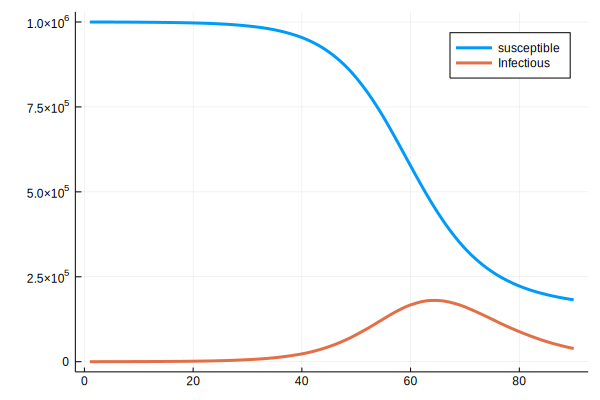

In [97]:
trial = sim_SIR_withRt();
fig_sim = plot([trial[2], trial[3]],labels=["susceptible" "Infectious"],lw=3)
savefig(fig_sim,"out/RtSIM")
fig_sim

#rt_est = 82
#Rtv = 90


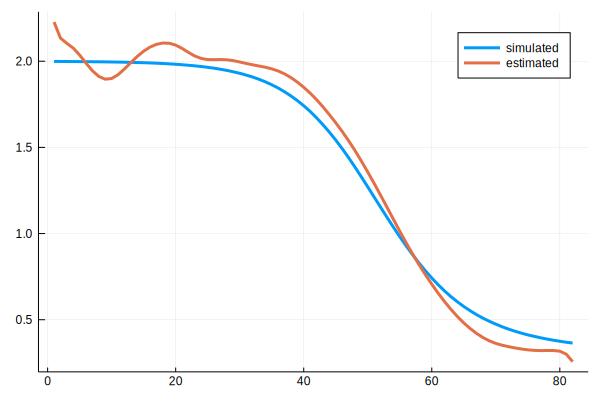

In [99]:
new_cases = trial[1]
cases = cumsum(new_cases)
infectives = [ cases[i]-cases[i-IFP] for i in IFP+1:length(cases) ]
smooth_inf = smooth_sequence(infectives)
rt_est = [ 1 + IFP * ((smooth_inf[i+1]-smooth_inf[i])/smooth_inf[i])
    for i in 1:length(smooth_inf)-1]
println("#rt_est = ",length(rt_est))
println("#Rtv = ",length(trial[6]))
plot([trial[6][IFP+2:end], rt_est ],labels=["simulated" "estimated"],lw=3)

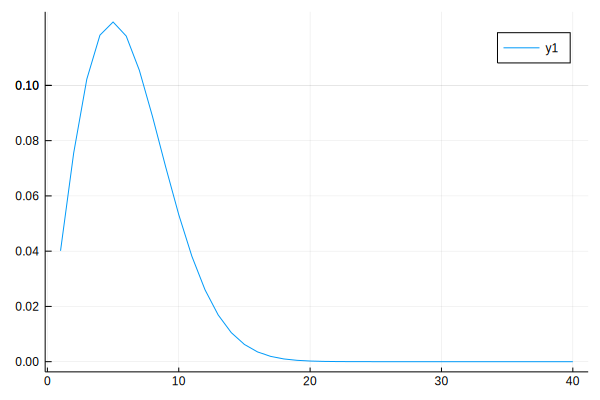

In [100]:
range = collect(1:1:40)
p_delay = [pdf.(Weibull(2, 7),t) for t in range]
p_delay = p_delay ./ sum(p_delay)
plot(range, p_delay)

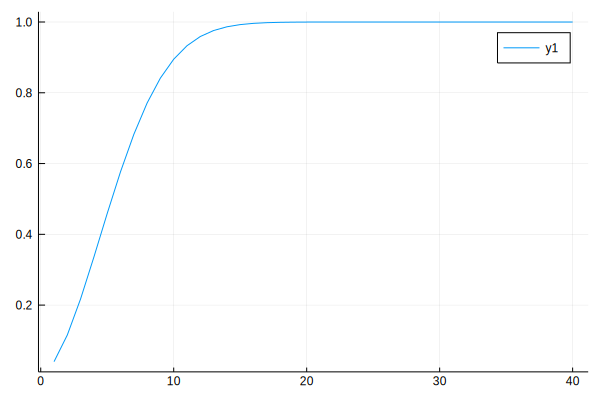

In [101]:
plot(cumsum(p_delay))

In [102]:
function estimate_onset(new_cases, p_delay)
    return reverse(conv(reverse(new_cases),p_delay))[length(p_delay):end]
end

estimate_onset (generic function with 1 method)

In [103]:
function adjust_onset(onset, p_delay)
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    cd = vcat(c_delay,ones(extras))
    adjusted = onset ./ reverse(cd)
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

In [104]:
sum(p_delay)

0.9999999999999998

In [105]:
onset = estimate_onset(diff(cases),p_delay)
adj = adjust_onset(onset,p_delay)

89-element Array{Float64,1}:
   76.30363570337977
   87.39179622836764
  100.22205023382958
  114.69137134533503
  130.91621681291053
  149.08937325324314
  169.70403959580744
  192.99706801704178
  218.8020977967626 
  247.90734042088843
  281.97477356723493
  321.90621750366654
  369.1906186821916 
    ⋮               
 4751.223907349968  
 4348.111938578571  
 4002.5475304455717 
 3708.7313258304084 
 3461.7870148444667 
 3253.640523776684  
 3085.450334027519  
 2934.5601027174216 
 2808.0018729756307 
 2694.8987035099403 
 2591.758053860813  
 2480.0000000000546 

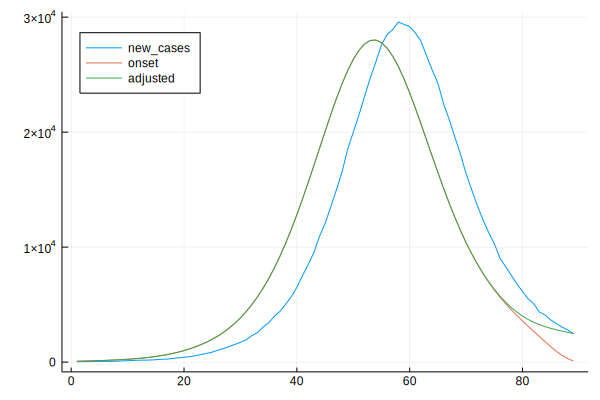

In [106]:
plot([diff(cases),onset,adj],labels=["new_cases" "onset" "adjusted"], legend=:topleft)

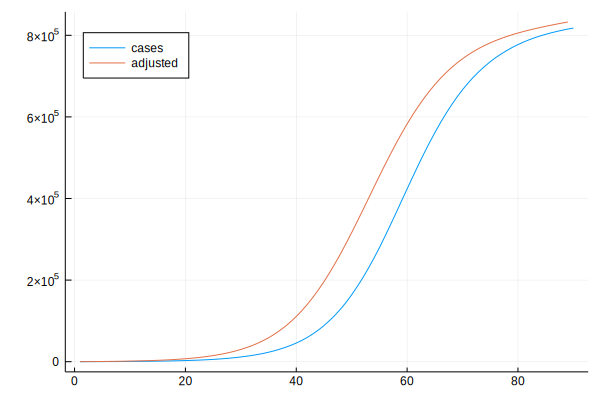

In [107]:
plot([cases,cumsum(adj)],labels=["cases" "adjusted"], legend=:topleft)

# Real-World Application to South African Data

In [112]:
output_url = "./"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
# parse date strings as Date
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
# select columns of interest and fill in missing rows with missing values
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
latest_date = maximum(data[:,:date])
# prepare to loop through each region and compute Rt values for each day
regions=names(data)[2:end]
# create an empty dataframe to hold Rt values
rtdf = DataFrame(date=Date[], province=String[], infs=Int64[], smooth_infs=Int64[],
                    rts=Float64[])
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa \n as of $latest_date")
fig_rts = plot(legendtitle="latest R",legend=:bottomleft,ylabel="R(t)", ylimits = [-1,3],
    title="tracking R(t) in South Africa \n as of $latest_date")
cases=[]
onset=[]
adj_cases=[]
for region in regions
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    onset = estimate_onset(diff(cases),p_delay)
    adj_cases = cumsum(adjust_onset(onset,p_delay))
    infectives = [ adj_cases[i]-adj_cases[i-IFP] for i in IFP+1:length(adj_cases) ]
    # lost IFP data points from infectives calc and 2 more from adjustment filter
    dates = data[IFP+2:end,:date] 
    max_inf = maximum(infectives)
    if(max_inf<100)
        println("skipping ... ",region," max(inf) = ",max_inf)
    else
        println("processing ... ",region," max(inf) = ",max_inf)
        smooth_inf = smooth_sequence(infectives)
        dates = dates[smooth_inf[:] .> 0]
        infectives = infectives[smooth_inf[:] .> 0]
        smooth_inf = smooth_inf[smooth_inf .> 0]
        rt_est = [ 1 + IFP * ((smooth_inf[i+1]-smooth_inf[i])/smooth_inf[i]) 
            for i in 1:length(smooth_inf)-1]
        
        for i in 1:length(dates)-1
            push!(rtdf,
            [dates[i] "$region" Int64(round(infectives[i])) Int64(round(smooth_inf[i])) rt_est[i] ]
            )
        end
        rt_score = round(last(rt_est),digits=2)
        if (region == :total)
            lab = "ZA-$rt_score"
        else
            lab = "$region-$rt_score"
        end
        plot!(fig_rts, dates[2:end], rt_est, lw=6,m=:circle,label=lab)
        count = Int64(round(infectives[end],digits=0))
        if (region == :total)
            lab = "ZA-$count"
        else
            lab = "$region-$count"
        end
        plot!(fig_inf, dates, smooth_inf,lw=6,m=:circle,label=lab)
        # plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=String(region))
    end
end
savefig(fig_rts,output_url*"out/RtLiveZA")
savefig(fig_inf,output_url*"out/InfLiveZA")
CSV.write(output_url*"out/provincial_rts.csv",rtdf)

processing ... EC max(inf) = 625.81197388329
skipping ... FS max(inf) = 47.51397299855263
processing ... GP max(inf) = 438.9712820817208
processing ... KZN max(inf) = 248.608252533528
skipping ... LP max(inf) = 13.193562779953979
skipping ... MP max(inf) = 21.968069193077845
skipping ... NC max(inf) = 11.550363783766908
skipping ... NW max(inf) = 29.504180709250505
processing ... WC max(inf) = 3777.330062879808
processing ... total max(inf) = 5076.840981546024


"./out/provincial_rts.csv"

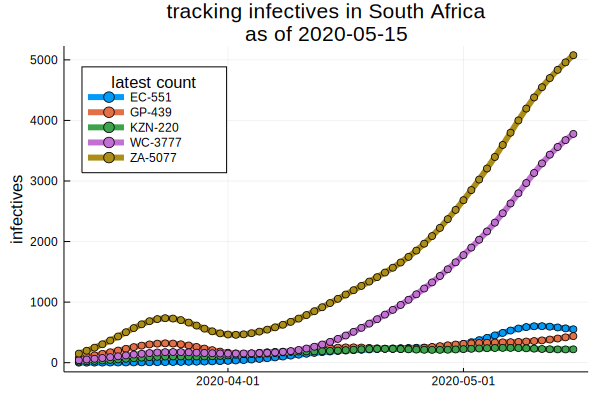

In [113]:
fig_inf

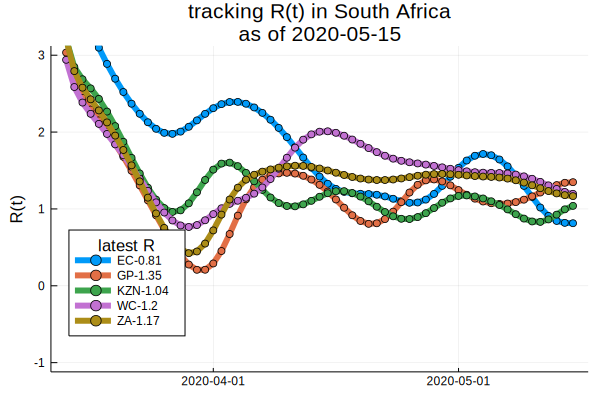

In [114]:
fig_rts

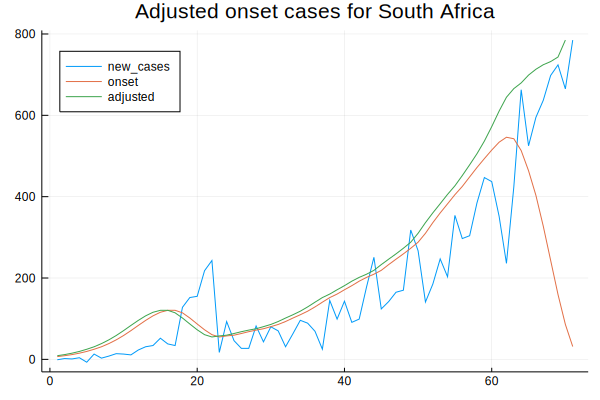

In [119]:
fig_adj_ZA = plot([diff(cases),onset,diff(adj_cases)],labels=["new_cases" "onset" "adjusted"], legend=:topleft,
title="Adjusted onset cases for South Africa")
savefig(fig_adj_ZA,output_url*"out/onsetAdjZA")
fig_adj_ZA